In [2]:

import warnings
warnings.filterwarnings(action='ignore')
############################################## 00. 필요한 파이썬 라이브러리 불러오기 #####################################################
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
import plotly
import plotly.graph_objects as go
import plotly.express as px


# import spark
import pydot 
from IPython.display import Image
import pyarrow as pa

from tqdm import tqdm
from datetime import datetime

## 전처리 ## 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

## 시계열 실습 ##
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf   ### acf pacf 그래프 생성 도구
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


import tensorflow_probability as tfp
from tensorflow_probability import sts

## 자체적으로 만든 모듈
from bike_data_analysis_class import *

################### 설정 ########################
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('seaborn-whitegrid')
%matplotlib inline

Text(0.3, 0.3, '한글')

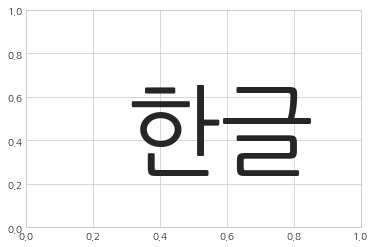

In [5]:
#한글 폰트 사용
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager,rc

#폰트 경로
font_path = "C:/Windows/Fonts/NanumGothic.TTF"

#폰트 이름 얻어오기
font_name = font_manager.FontProperties(fname=font_path).get_name()

#font 설정
plt.rc('font', family=font_name)

#시범 출력
plt.text(0.3, 0.3, '한글', size=100)

# 시계열 데이터

## 추가 전처리

### 데이터셋 불러오기

In [5]:
bike_df = pd.read_parquet("bike+station_preprocessed_2021_성북구.parquet")
bike_df.head(1)

,자전거번호,대여일시,대여 대여소번호,대여 대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,...,대여시각,보관소(대여소명),소재지,주소,위도,경도,설치시기,거치대수-LCD,거치대수-QR,운영방식
425177,SPB-50927,2021-01-01 06:33:10,1302,한성대입구역6번출구 뒤,0,2021-01-01 06:40:10,342,대학로 마로니에공원,0,7.00,...,6,한성대입구역6번출구 뒤,성북구,서울특별시 성북구 동소문로 1,37.58876419,127.0063095,2017-06-20,5,None,LCD


### 시각정보를 index로 지정.

In [2]:
bike_df = pd.read_parquet("bike+station_preprocessed_2021_성북구.parquet")

#인덱스 시각정보로 변경
bike_df.set_index(bike_df["대여일시"],inplace=True)
#필요없는 열 삭제
bike_df.drop(['대여일시','대여거치대','반납거치대','이용시간'],axis=1,inplace=True)
#거치대수의 Nonetype 결측값을 0으로 변경
bike_df[["거치대수-LCD","거치대수-QR"]] = bike_df[["거치대수-LCD","거치대수-QR"]].fillna(value=0)
#거치대수의 astype을 object에서 정수형으로 변경
bike_df = bike_df.astype({'거치대수-LCD':'int32','거치대수-QR':'int32'})
#LCD,QR 방식에 차이를 두지 않으므로 합산하여, 거치대의 총 거치대수 파악
bike_df["거치대수"]=bike_df[["거치대수-LCD","거치대수-QR"]].sum(axis=1)
#필요없는 열 삭제
bike_df.drop(["거치대수-LCD","거치대수-QR"],axis=1,inplace=True)

# apply 함수를 통한 계절 column 생성
def make_season_column(datetime):
    if str(datetime)>='2021-03' and str(datetime) < '2021-06':
        return '봄'
    elif str(datetime)>='2021-06' and str(datetime) < '2021-09':
        return '여름'
    elif str(datetime)>='2021-09' and str(datetime) < '2021-12':
        return '가을'
    elif str(datetime)>='2021-12' or str(datetime) < '2021-03':
        return '겨울'
bike_df["대여계절"]= pd.Series(bike_df.index).apply(make_season_column).values

# 특정 시간 단위로 리샘플링
def resampling(df,rule):
    count_by_time_interval = pd.DataFrame(df.resample(rule=rule).count()["자전거번호"])
    count_by_time_interval.rename(columns= {'자전거번호':'대여량'},inplace=True) 
    return count_by_time_interval

bike_df_count_by_1h = resampling(bike_df,'1h')
bike_df_count_by_1h.head()


,대여량
대여일시,
2021-01-01 00:00:00,19
2021-01-01 01:00:00,18
2021-01-01 02:00:00,7
2021-01-01 03:00:00,6
2021-01-01 04:00:00,8


### 강수량데이터 추가

- 기상누리 사이트의 2021 서울시 10분간격 강수량 데이터를 참고하여, 위 index에 맞게 전처리한 데이터

In [8]:
rainfall_file_name = "성북구_2021_1시간별_강수량"
seongbuk_rainfall_1h = pd.read_parquet(rainfall_file_name)
seongbuk_rainfall_1h.head()

,1시간우량
자료수집 시각,
2021-01-01 00:00:00,0.00
2021-01-01 01:00:00,0.00
2021-01-01 02:00:00,0.00
2021-01-01 03:00:00,0.00
2021-01-01 04:00:00,0.00


### Input Data 생성

In [9]:
# 시계열 데이터에 맞게 input 데이터 새로 생성.

def make_input_df(df):
    input_df = pd.DataFrame(index=df.index)
    input_df["대여월"] = df.index.strftime('%m')
    input_df["대여요일"] = df.index.strftime('%a')
    input_df["대여시각"] = df.index.strftime('%H')
    input_df["대여계절"] = pd.Series(df.index).apply(make_season_column).values
    input_df["1시간강수량"] = seongbuk_rainfall_1h["1시간우량"]
    input_df["대여량"] = df["대여량"]
    display(input_df)
    return input_df
    
input_bike_df = make_input_df(bike_df_count_by_1h)


,대여월,대여요일,대여시각,대여계절,1시간강수량,대여량
대여일시,,,,,,
2021-01-01 00:00:00,01,Fri,00,겨울,0.00,19
2021-01-01 01:00:00,01,Fri,01,겨울,0.00,18
2021-01-01 02:00:00,01,Fri,02,겨울,0.00,7
2021-01-01 03:00:00,01,Fri,03,겨울,0.00,6
2021-01-01 04:00:00,01,Fri,04,겨울,0.00,8
...,...,...,...,...,...,...
2021-12-31 19:00:00,12,Fri,19,겨울,0.00,52
2021-12-31 20:00:00,12,Fri,20,겨울,0.00,36
2021-12-31 21:00:00,12,Fri,21,겨울,0.00,48


### Plotly 라이브러리를 통해 시간대별 자전거 대여량 그리기

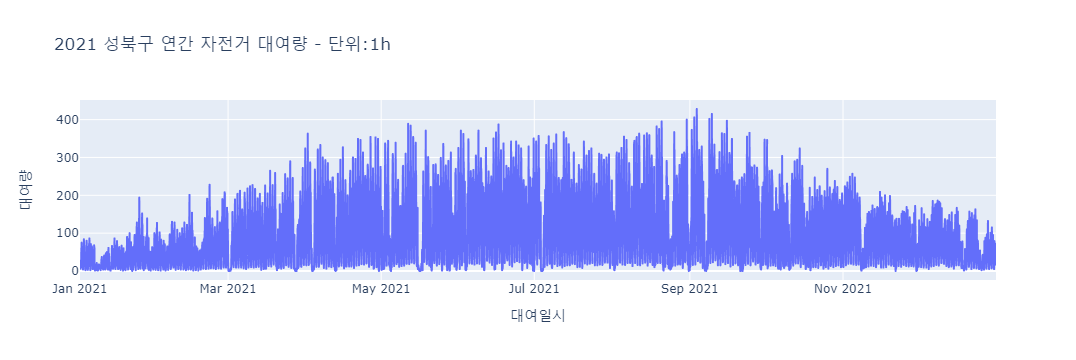

In [ ]:
def draw_pxline(df):
    fig = px.line(df, x=df.index, y=df["대여량"],title="2021 성북구 연간 자전거 대여량 - 단위:1h")
    fig.show()
    
draw_pxline(input_bike_df)

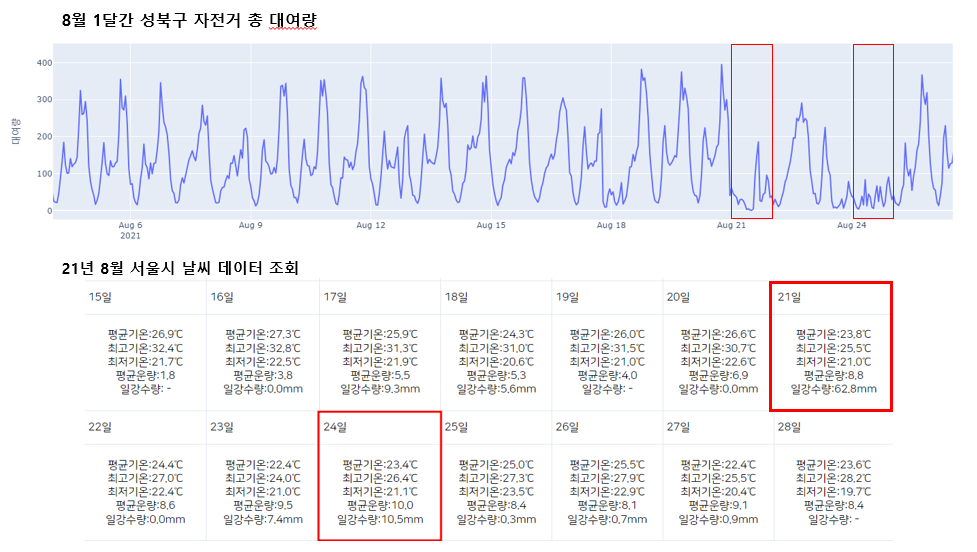

In [33]:
Image("C:/Users/Hoonyong/내 드라이브/jeong-term/공공자전거데이터/rainy_day.png", width=1500, height=1000)

- 중간에 빠져있는 부분이 듬성듬성 보인다.
- 예를 들어, 5월 16일의 데이터는 시계열의 영향을 받지 않고 데이터가 없다.
- 날씨 때문인가? 해서 찾아보았더니, 비가 온 날이다.
- 강수량에 영향을 받는다는 것을 알 수 있다.


# 시계열 데이터 분석 방법론 

## 해당 데이터는 정상성(Stationary)를 만족하는가? 

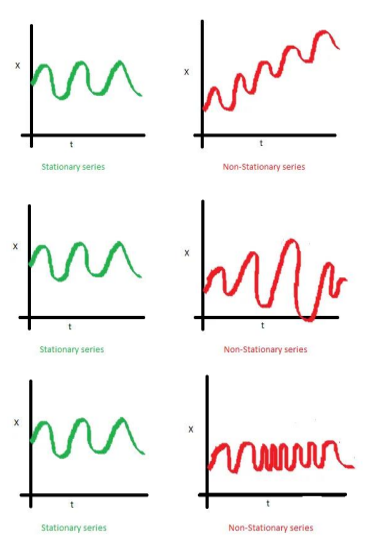

In [18]:
Image("C:/Users/Hoonyong\내 드라이브/jeong-term/공공자전거데이터/station-nonstation.png",height=600,width=500)

### Seasonal_Decompose

- 2021.06 데이터를 seasonal_decompose

<Figure size 432x288 with 0 Axes>

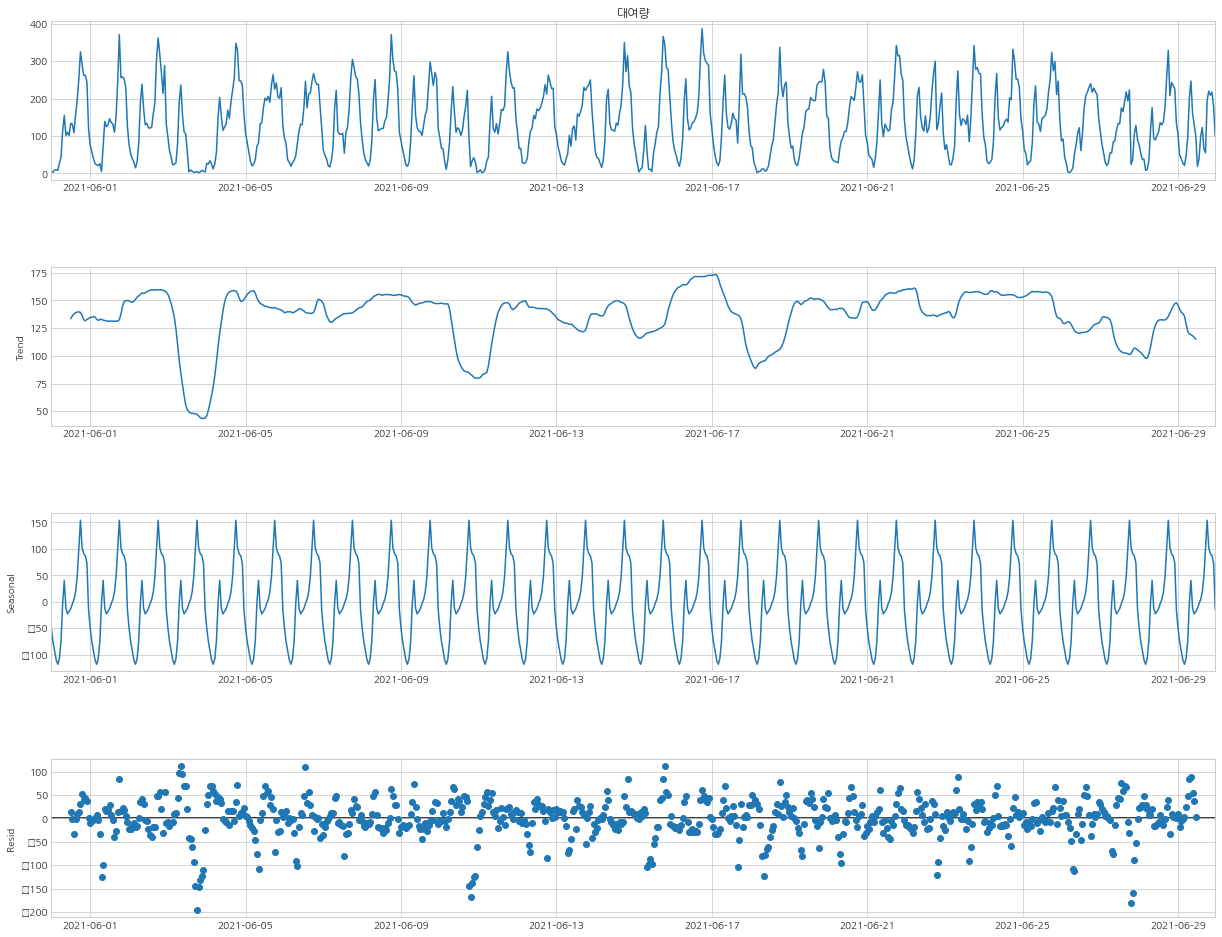

In [21]:
result = seasonal_decompose(input_bike_df['대여량'][24*150:24*180], model='additive')

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(20, 15)

### ACF, PACF plot

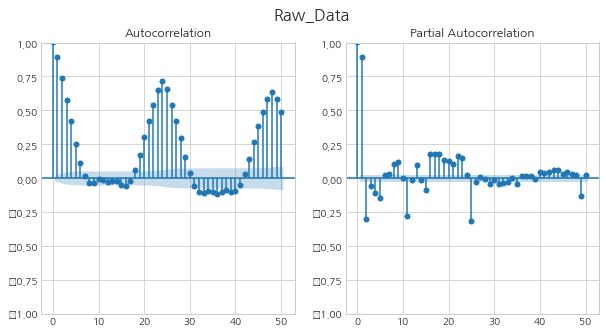

In [40]:
def draw_acf_pacf_plot(data,title,figsize=(10,5),fontsize=16):
    lags = 50
    fig,ax = plt.subplots(1,2,figsize=figsize)
    sm.graphics.tsa.plot_acf(data.values.squeeze(),lags=lags, ax=ax[0])
    sm.graphics.tsa.plot_pacf(data.values.squeeze(),lags=lags, ax=ax[1])
    fig.suptitle(title,fontsize=fontsize)
    plt.show()

draw_acf_pacf_plot(train,'Raw_Data')

- ACF가 빠르게 감소하고 sine파 형태를 띠고 있는 것을 보아, 정상성을 띠는 데이터인 것 같다.
- PACF 또한 유의미한 막대 뒤에 급격히 길이가 감소하는 부분이 있는 부분을 보아 정상성을 띠는 데이터인 것 같다.
- 하지만 확실하지는 않다. 

### ADF 검정

- 귀무가설 : 해당 데이터셋은 non-stationary 하다.
- 대립가설 : 해당 데이터셋은 stationary 하다.

In [ ]:
result = adfuller(input_bike_df["대여량"])
print('ADF Statistic: %f' % result[0])
print('p-value: %s' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.682756
p-value: 4.2422710720765317e-14
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


- ACF test 결과, P-value 값이 매우 작으므로 귀무가설을 기각하고 대립가설을 차용한다.
- 즉, 데이터셋은 stationary 하며, 차분이 필요하지 않다. 

## 차분 

- 만약 정상성을 띠지 않는다면 차분을 통해 원본 데이터 변형

In [ ]:
## 1차 차분 , Differencing

diff_train = train.copy()
diff_train = diff_train.diff()
diff_train = diff_train.dropna() # 차분하면 1개 행에 대해 결측치가 생기기 때문에 제거 필요

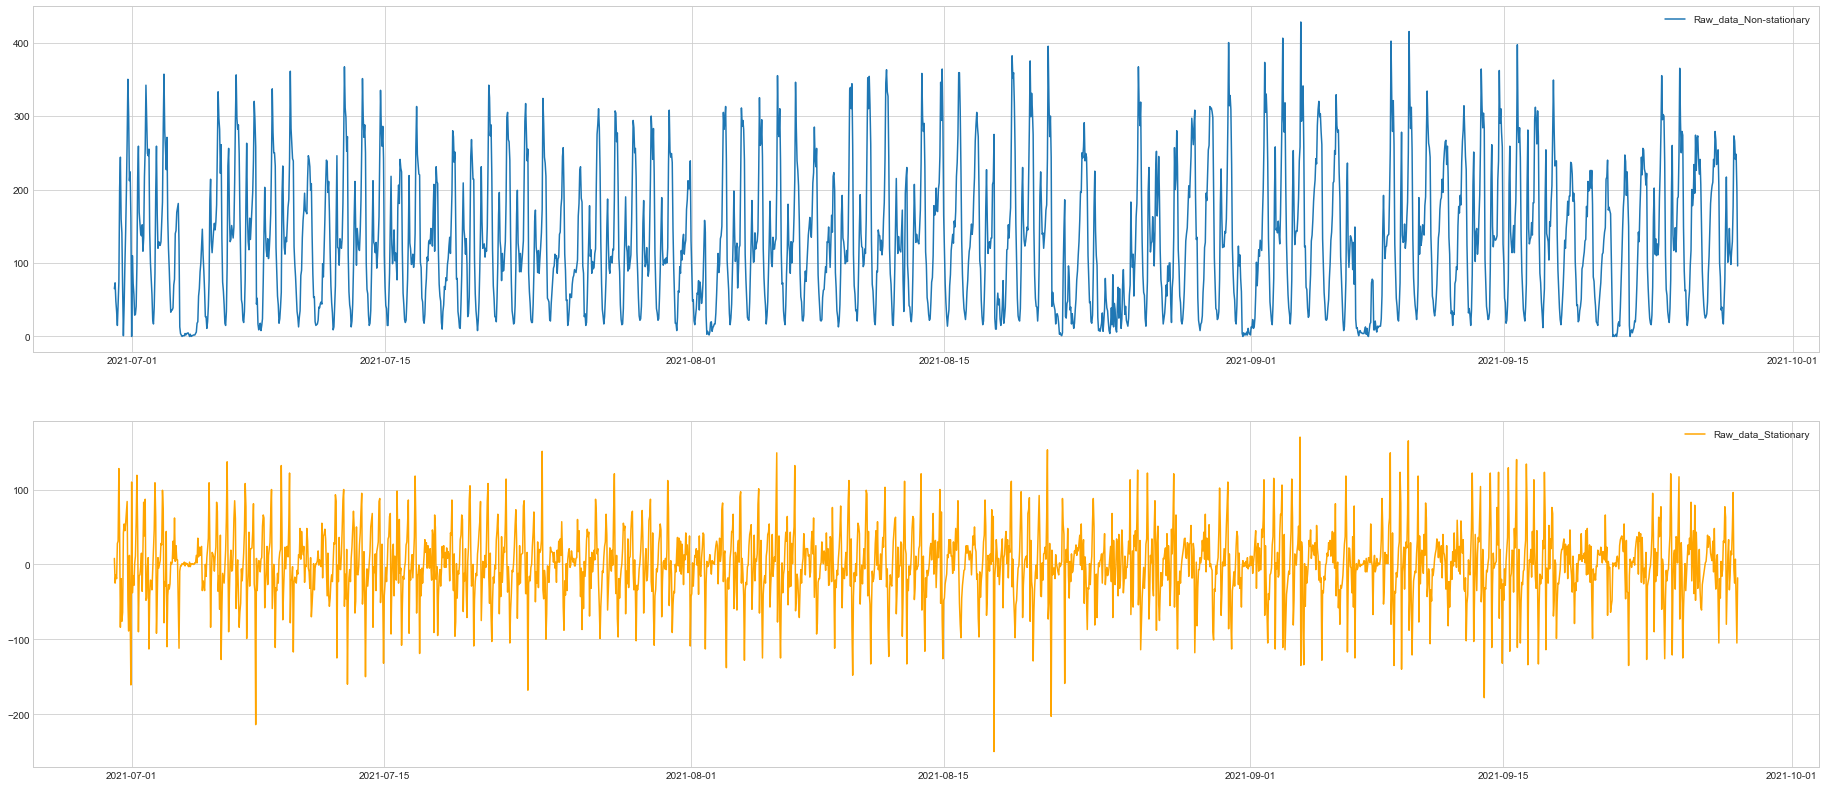

In [ ]:
# 0 diff, 1 diff 두 그래프 비교

# 0 diff
plt.figure(figsize=(32,14))
plt.subplot(211)
plt.plot(train[24*30*6:24*30*9])
plt.legend(['Raw_data_Non-stationary'])

# 1 diff
plt.subplot(212)
plt.plot(diff_train[24*30*6:24*30*9],color='orange')
plt.legend(['Raw_data_Stationary'])

plt.show()

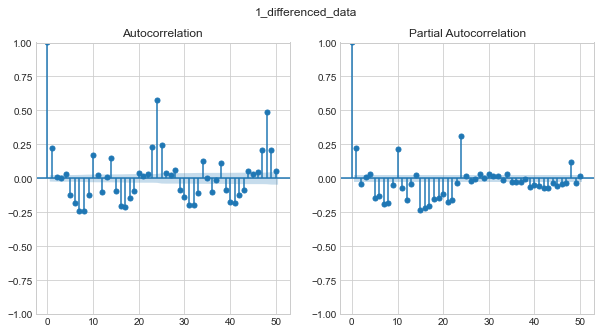

In [ ]:
# 1차분 데이터에 대한 ACF와 PACF plot
draw_acf_pacf_plot(diff_train,'1_differenced_data')

# Model fitting

## ARIMA 모형
- 외생변수 고려 x, 오직 1년간의 1시간당 자전거 수요량 데이터 고려

### Parameter 설정 - p,d,q

- ARIMA 모델은 p,d,q 세가지 변수를 parameter로써 받음
- p = 자기회귀 부분의 차수. 쉽게 말해서, 몇 단위마다 상관 있는 데이터가 등장하는가?

- d = 차분 횟수. 차분이란 시계열이 정상성을 갖지 않을 때 현재 데이터 – 이전 데이터를 구하여 시계열을 새로 구성한다. 해당 연구에서는 d=0으로 설정

- q = 이동평균 부분의 차수. 몇 단위 이전까지의 평균값을 계산하여 예측에 반영할 것인가?

- 적절한 parameter 값을 찾는 것은 중요하지만, 이는 시간이 많이 소요되는 작업.
- 특히 p , q 값이 커질수록 **연산속도가 매우 느려지므로** 적정선에서 타협 필요


### ACF(AutoCorrelation Function), PACF(Partial AutoCorrelation Function)

- ACF 그래프가 sine 파형인 경우 그 주기값, PACF에서 의미 있는 막대가 등장하는 마지막 시점의 값이 최적의 p 값이라고 알려져 있음.
- **p = 24** 를 선택

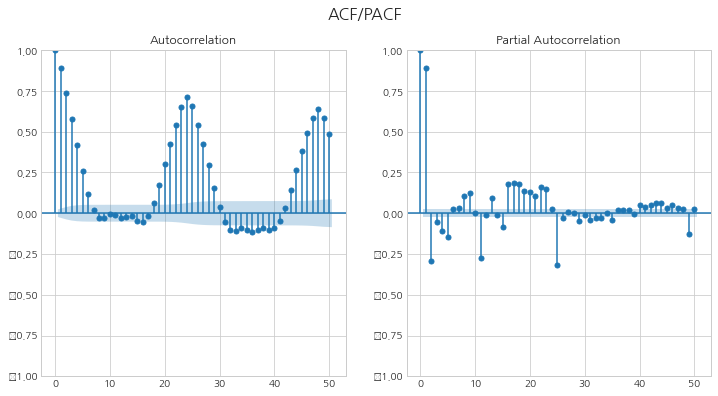

In [43]:
draw_acf_pacf_plot(train,'ACF/PACF',figsize=(12,6))

### ARIMA 모델 피팅 

In [44]:
# 분리
train, test = train_test_split(input_bike_df["대여량"],test_size=0.2, shuffle=False)

# 모델
model = ARIMA(train.values,order=(24,0,1))  # 비계절성 요인만 fitting 했고, 외부 변수 없으므로 ARIMA 모형임.
model_fit = model.fit()
display(model_fit.summary())

# 예측
prediction = model_fit.forecast(len(test))
predicted_value = prediction
predict_index = list(test.index)
rmse = np.sqrt(sum((predicted_value - test)**2/len(test)))
print(f"rmse score is : {rmse}")

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7008
Model:                ARIMA(24, 0, 1)   Log Likelihood              -33822.060
Date:                Sun, 12 Jun 2022   AIC                          67698.120
Time:                        19:20:36   BIC                          67883.200
Sample:                             0   HQIC                         67761.892
                               - 7008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        104.1664     10.624      9.805      0.000      83.345     124.988
ar.L1          0.2208      0.031      7.132      0.000       0.160       0.282
ar.L2          0.5642      0.031     18.004      0.000       0.503       0.626
ar.L3         -0.0924      0.014     -6.632      0.000      -0.120      -0.065
ar.L4          0.0318      0.014      2.334      0.020       0.005       0.058
ar.L5         -0.0552      0.014     -3.949      0.000      -0.083      -0.028
ar.L6         -0.0973      0.015     -6.654      0.000      -0.126      -0.069
ar.L7         -0.0614      0.016     -3.958      0.000      -0.092      -0.031
ar.L8         -0.0606      0.015     -4.103      0.000      -0.090      -0.032
ar.L9         -0.0042      0.014     -0.309      0.757      -0.031       0.023
ar.L10         0.2530      0.012     20.569      0.000       0.229       0.277
ar.L11         0.0398      0.015      2.571      0.010       0.009       0.070
ar.L12        -0.1967      0.013    -15.156      0.000      -0.222      -0.171
ar.L13         0.0069      0.013      0.528      0.597      -0.019       0.033
ar.L14         0.1506      0.013     11.908      0.000       0.126       0.175
ar.L15        -0.1073      0.013     -8.100      0.000      -0.133      -0.081
ar.L16        -0.1337      0.015     -8.850      0.000      -0.163      -0.104
ar.L17         0.0244      0.015      1.592      0.111      -0.006       0.054
ar.L18         0.0674      0.015      4.613      0.000       0.039       0.096
ar.L19         0.0574      0.014      4.165      0.000       0.030       0.084
ar.L20         0.0474      0.013      3.695      0.000       0.022       0.073
ar.L21        -0.0040      0.014     -0.296      0.767      -0.031       0.023
ar.L22         0.0040      0.013      0.315      0.752      -0.021       0.029
ar.L23         0.0471      0.012      4.091      0.000       0.025       0.070
ar.L24         0.2254      0.010     23.264      0.000       0.206       0.244
ma.L1          0.7393      0.031     24.056      0.000       0.679       0.799
sigma2       926.5813     10.554     87.798      0.000     905.897     947.266
===================================================================================
Ljung-Box (L1) (Q):                   5.76   Jarque-Bera (JB):              4121.40
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

rmse score is : 57.23137853465707


In [45]:
# 참값, 예측값을 받아 예측 결과를 본 데이터와 함께 시각화
# 버젼 1,외생변수 없는 모델 

def draw_test_predicted_plot(true_value,pred_value,title="Model",figsize=(32,8)):
    fig, ax = plt.subplots(figsize=figsize)
    # ax.rc('font', family=font_name)
    ax.plot(list(test.index),pred_value, label = 'prediction',color='y',linewidth=3)
    true_value.plot(ax=ax,color='#1f77b4')
    ax.vlines(list(test.index)[0],0,max(true_value),linestyle='--',color='r',label='예측시작지점',linewidth=10)
    ub = pred_value + 1*np.std(pred_value)
    lb = pred_value - 1*np.std(pred_value)
    ax.set_xlabel('대여일시',fontsize=16)
    ax.set_ylabel('대여량(대)',fontsize=16)
    ax.set_title(title,fontsize=20)
    ax.legend(fontsize=16)
    ax.fill_between(list(test.index),ub,lb, label = '0.95 prediction interval', color='k', alpha=0.1)
    fig.show()

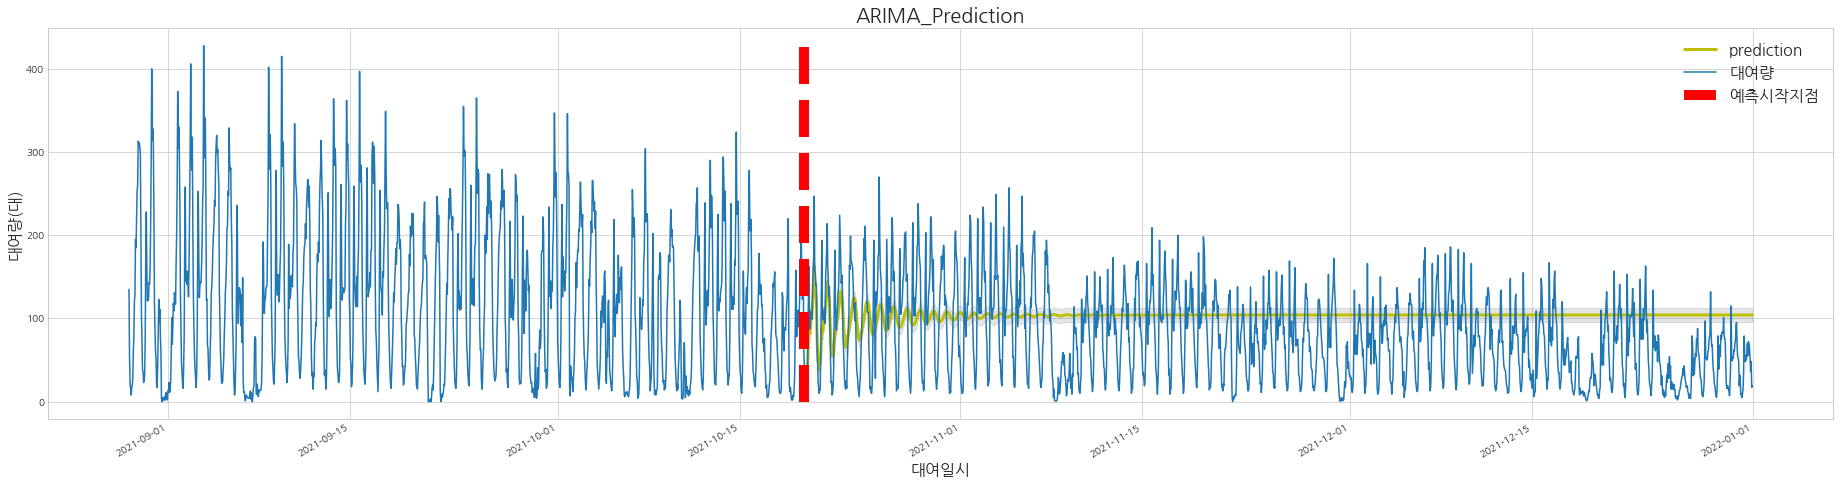

In [46]:
draw_test_predicted_plot(input_bike_df["대여량"][24*30*8:],predicted_value,"ARIMA_Prediction")

- 결과가 좋지 않음
- 계절성 요인까지 고려한 SARIMA 모형 사용해보자

## SARIMA 모형

- 모델 피팅 > 예측 부분까지 반복되는 부분 함수화

In [49]:
## 모델 피팅 > 예측까지 반복되는 부분 함수화
## 버전 1, 외생변수 없는 모델

def model_prediction(model,test):
    model_fit = model.fit()
    predicted_value = model_fit.forecast(len(test))
    AIC = model_fit.aic
    return predicted_value,AIC


AIC : 66596.24843628533
rmse score is : 42.12774673145393


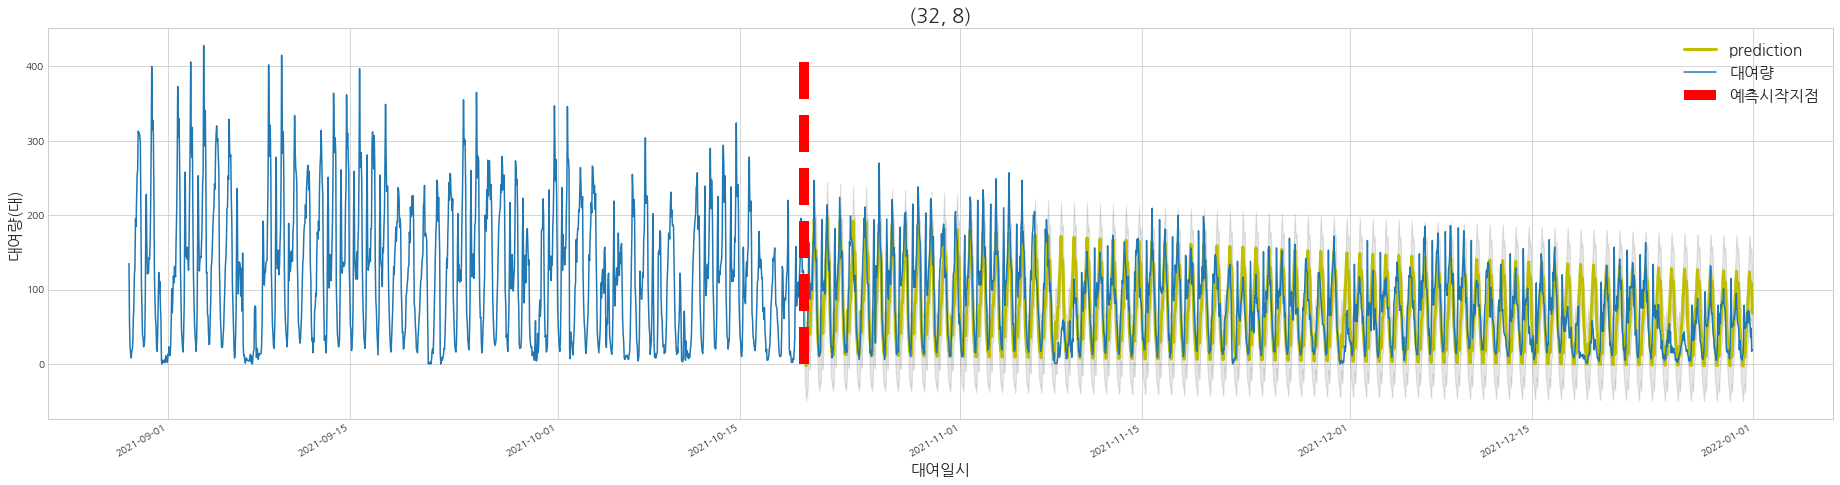

In [50]:
#SARIMA 모형
train, test = train_test_split(input_bike_df["대여량"],test_size=0.2, shuffle=False)
model = SARIMAX(train.values,order=(24,0,24),sorder=(24,0,24,24))   ## 모델 생성
predicted_value,AIC = model_prediction(model,test)              ## 모델 피팅 후 예측값 도출
draw_test_predicted_plot(input_bike_df["대여량"][24*30*8:],predicted_value,(32,8))   ## 시각화

## prediction, predicted 주의
print(f"AIC : {AIC}")
rmse = np.sqrt(sum((predicted_value - test)**2/len(test)))
print(f"rmse score is : {rmse}")

## SARIMAX모형(외생변수 삽입)

### Label Encoder를 이용한 외생변수 레이블화

- 외생변수 처리를 위한 데이터 레이블링
- ex. 월요일 > 0, 화요일 > 1 같은 변환

In [84]:

labeled_input_bike_df = input_bike_df.copy()

for name in ["대여요일","대여계절"]:
    encoder = LabelEncoder()
    encoder.fit(labeled_input_bike_df[name])
    labels = encoder.transform(labeled_input_bike_df[name])
    labeled_input_bike_df[name] = labels

labeled_input_bike_df = labeled_input_bike_df.astype({"대여월":'int64',"대여요일":'int64',"대여시각":'int64',"대여계절":'int64'})
labeled_input_bike_df.head()


,대여월,대여요일,대여시각,대여계절,1시간강수량,대여량
대여일시,,,,,,
2021-01-01 00:00:00,1,0,0,1,0.00,19
2021-01-01 01:00:00,1,0,1,1,0.00,18
2021-01-01 02:00:00,1,0,2,1,0.00,7
2021-01-01 03:00:00,1,0,3,1,0.00,6
2021-01-01 04:00:00,1,0,4,1,0.00,8


### 모델 피팅 및 그래프 그리는 부분 함수화

In [67]:

## 모델 피팅 > 예측까지 반복되는 부분 함수화
def model_prediction_v2(model,y_test):
    model_fit = model.fit()
    predicted_value = model_fit.get_forecast(len(y_test),exog=X_test).predicted_mean   ## .predicted_mean을 해야 예측값임.
    AIC = model_fit.aic
    print(f"AIC : {AIC}")
    rmse = np.sqrt(sum((predicted_value - y_test)**2/len(y_test)))
    print(f"rmse score is : {rmse}")
    print(f"r^2_score is : {r2_score(y_test,)}")
    return predicted_value,AIC

# 참값, 예측값을 받아 plotting 해줌
# 받아야 하는 변수 : 참값, 모델이 내어준 예측값, 테스트(대여량), figsize
def draw_test_predicted_plot_v2(true_value,pred_value,y_test,figsize):
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(list(y_test.index),pred_value, label = 'prediction',color='orange',linewidth=3)
    true_value.plot(ax=ax,color='#1f77b4',label='true')
    ax.vlines(list(y_test.index)[0],0,400,linestyle='--',color='r',label='pred_start',linewidth=10)
    ub = pred_value + 1*np.std(pred_value)
    lb = pred_value - 1*np.std(pred_value)
    ax.set_xlabel('Rent-date',fontsize=16)
    ax.set_ylabel('Rent-amount',fontsize=16)
    ax.fill_between(list(y_test.index),ub,lb, label = '0.95 prediction interval', color='k', alpha=0.1)
    ax.legend(fontsize=16)
    fig.show()

### SARIMAX 성능 개선을 위해 고려해야 할 사항

- 추가적인 column 고려. 기온,습도 등 등
- 목적은 실시간 수요예측 ~ 1시간 직전의 대여량을 사용가능하다면 예측에 반영
- auto_arima 사용하여 최적의 parameter 사용


## 추가 Column 고려

### 데이터 레이블링 및 1시간전 대여량 column 추가

In [85]:
## 1시간 직전의 column 추가
hr_before_labeled_input_bike_df = labeled_input_bike_df.copy()
rent = hr_before_labeled_input_bike_df["대여량"].to_list()
rent.insert(0,15)
rent.pop()
hr_before_labeled_input_bike_df["1시간전대여량"]=rent
hr_before_labeled_input_bike_df = hr_before_labeled_input_bike_df.reindex(columns=["대여월","대여요일","대여시각","대여계절","1시간강수량","1시간전대여량","대여량"])

In [86]:
hr_before_labeled_input_bike_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2021-01-01 00:00:00 to 2021-12-31 23:00:00
Freq: H
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   대여월      8760 non-null   int64  
 1   대여요일     8760 non-null   int64  
 2   대여시각     8760 non-null   int64  
 3   대여계절     8760 non-null   int64  
 4   1시간강수량   8760 non-null   float64
 5   1시간전대여량  8760 non-null   int64  
 6   대여량      8760 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 547.5 KB


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    대여량   No. Observations:                 7008
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -35022.559
Date:                Tue, 07 Jun 2022   AIC                          70061.118
Time:                        17:42:14   BIC                          70115.956
Sample:                    01-01-2021   HQIC                         70080.013
                         - 10-19-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
대여월            3.0943      0.294     10.534      0.000       2.519       3.670
대여요일           0.1653      0.318      0.520      0.603      -0.457       0.788
대여시각           0.8845      0.130      6.797      0.000       0.629       1.140
대여계절           3.8640      0.577      6.701      0.000       2.734       4.994
1시간강수량        -7.0757      0.374    -18.901      0.000      -7.809      -6.342
1시간전대여량        0.6836      0.021     33.066      0.000       0.643       0.724
ar.L1          0.4025      0.023     17.501      0.000       0.357       0.448
sigma2      1283.3101     15.035     85.357      0.000    1253.843    1312.778
===================================================================================
Ljung-Box (L1) (Q):                   2.25   Jarque-Bera (JB):              1906.67
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

AIC : 70061.11757253311
rmse score is : 35.84429905833257


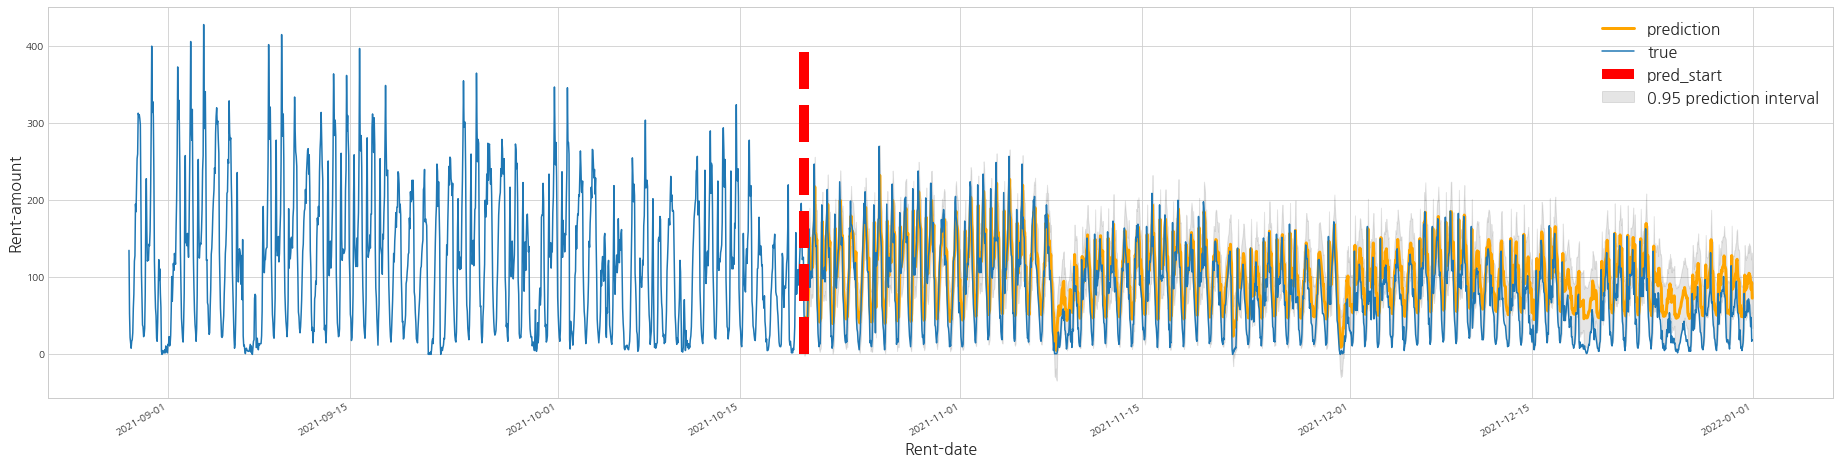

In [55]:
## 1년 전체
data = hr_before_labeled_input_bike_df

# 데이터 분리
X_train,X_test,y_train,y_test = train_test_split(data.iloc[:,:-1],data["대여량"],test_size=0.2,shuffle=False)

# 모델 생성
model = SARIMAX(endog = y_train,exog=X_train, order=(24,0,0),sorder=(24,0,0,1))

# 예측값 반환
predicted_value,AIC = model_prediction_v2(model,y_test)

# 시각화
draw_test_predicted_plot_v2(data["대여량"][24*30*8:],predicted_value,y_test,(32,8))

## Auto-Arima (Parameter Optimization)

- 최적의 q 값 찾기

In [ ]:
## auto-arima for 1yr-exod, differencing?, 1시간전 대여량 추가 
data = hr_before_labeled_input_bike_df
X_train,X_test,y_train,y_test = train_test_split(data.iloc[:,:-1],data["대여량"],test_size=0.2,shuffle=False)
# auto_arima(y_train,exogeneous=X_train,max_p=5,max_q=5,seasonal=True, max_P=5,max_Q=5,m=24,trace=True,suppress_warnings=True,stepwise=False)

AIC_list = {}
for j in range(25):
    try:
        (p,P,q,Q) = (24,24,j,j)
        
        # 모델 생성
        model = SARIMAX(endog = y_train,exog=X_train, order=(p,0,q),sorder=(P,0,Q,1))  ##<< auto_arima에서 최적 parameter 사용

        # 예측값 반환
        predicted_value,AIC = model_prediction_v2(model,y_test)
        AIC_list[(p,q)]=AIC
        print(f"AIC score for (p,q) tuple{(p,q)} --> {AIC_list[(p,q)]:.2f}")
        
    except:
        print("Error occured")
        continue

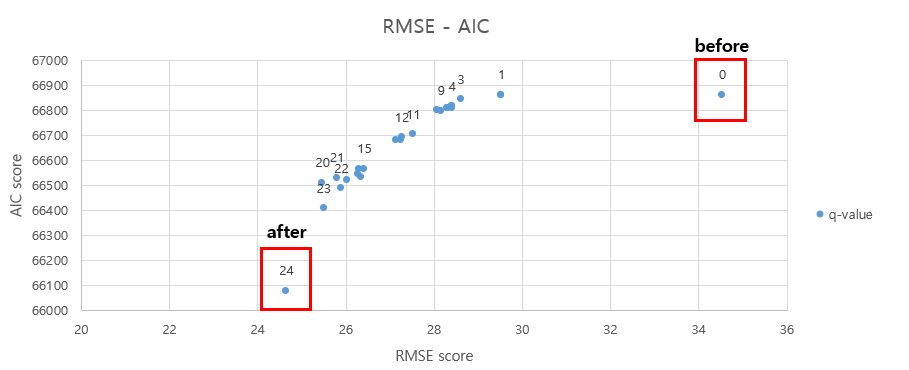

In [64]:
Image(filename='C:/Users/Hoonyong/내 드라이브/jeong-term/공공자전거데이터/q-optimization-SARIMAX.png')

### p,q = 24,24

AIC for (p,q) = (24,24) : 66063.58


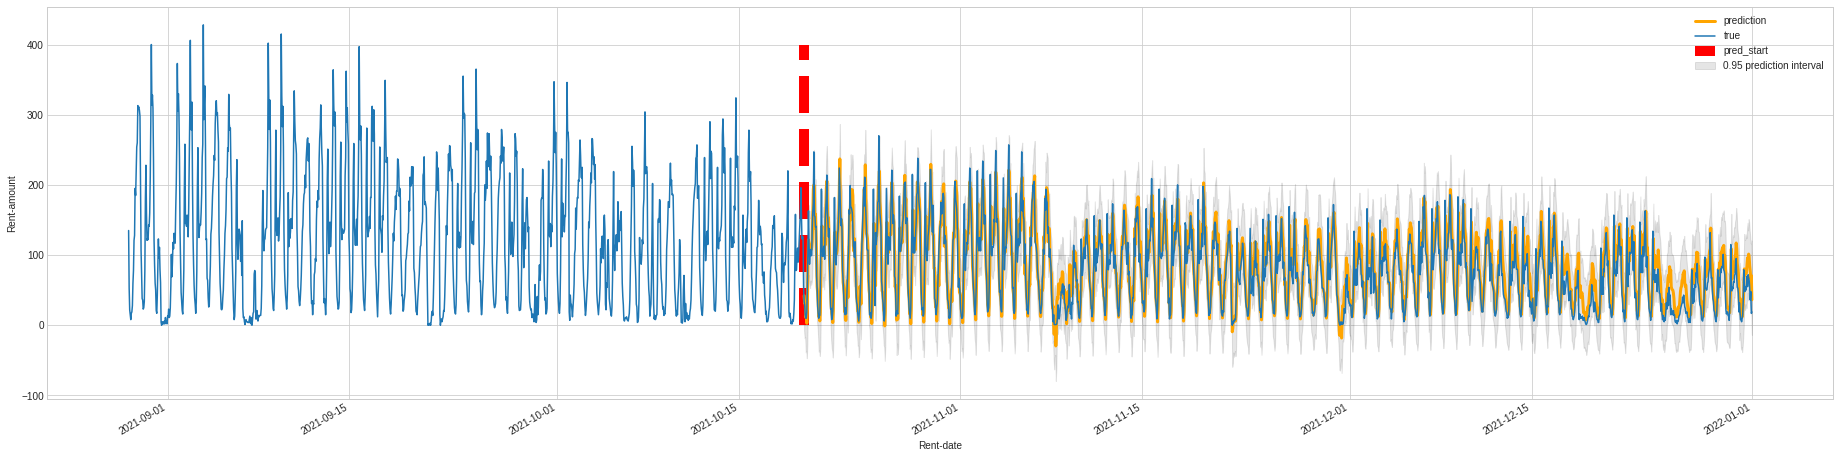

In [35]:
## 1년 전체
data = hr_before_labeled_input_bike_df

# 데이터 분리
X_train,X_test,y_train,y_test = train_test_split(data.iloc[:,:-1],data["대여량"],test_size=0.2,shuffle=False)

# 모델 생성
model = SARIMAX(endog = y_train,exog=X_train, order=(24,0,24),sorder=(24,0,24,1)) 

# 예측값 반환
predicted_value,AIC = model_prediction_v2(model,y_test)

# 시각화
draw_test_predicted_plot_v2(data["대여량"][24*30*8:],predicted_value,y_test,(32,8))


# 결론

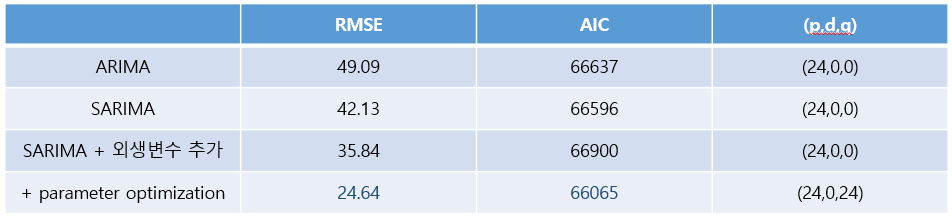

In [83]:
Image("C:/Users/Hoonyong/내 드라이브/jeong-term/공공자전거데이터/Result.png")

# 향후 연구 계획

## 실시간 동적 계획법
- 새로운 데이터셋이 들어왔을 때 모델을 처음부터 학습하는 것이 아닌, 강화학습 방식을 통한 모델 업데이트로 최신 데이터를 반영한 예측모델 구축

## 수요 예측 > 개별 거치소의 “재고량“ 예측
- 분석에 사용한 데이터셋은 자전거 번호 별로 거치소간 이동을 알려주기 때문에, O/D Matrix 구축 가능

## 재배치 모형
- 거치소의 자전거 재고량이 0이 되는 시간을 최소화 하는 재배치 모형
- 거치소의 예상 재고량 graph를 도출하고 ,해당 부분이 음수가 되는 부분의 면적을 최소화하는 재배치 모형
